# Louisiana Pollution EDA

This notebook visualizes pollution data on particulate emissions from Louisiana using data from the EPA.

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [ ]:
# Make a dictionary to associate to each year the relevant dataframe
years = [x for x in range(2000,2025)]
LA_dict = {y:0 for y in years}

In [ ]:
# .csv files are obtained from https://aqs.epa.gov/aqsweb/airdata/download_files.html, under Particulates - PM2.5 FRM/FEM Mass (88101)
# Need to download years 2000-2024 and place them in ./epa directory
# Takes about 25s to run

for year in years:
    gen = pd.read_csv('./epa/daily_88101_'+str(year)+'.csv', 
                    chunksize=10000000, 
                    usecols=['City Name', 
                            'State Name', 
                            'Local Site Name', 
                            'Latitude','Longitude', 
                            'Date Local', 
                            'Arithmetic Mean', 
                            'Sample Duration',
                            '1st Max Value',
                            '1st Max Hour'])

    LA_dict[year] = pd.concat((x.query("`State Name` == 'Louisiana'") for x in gen), ignore_index=True)

In [ ]:
# Some sites are more up to date than others. E.g. some cities report 2024 data only as far as June, while most data goes thru October

LA_dict[2024]['Local Site Name'].value_counts()

Local Site Name
Port Allen              1366
Capitol                  793
Marrero                  671
I-610                    670
Chalmette Vista          637
Westlake                 624
Kenner                   575
Vinton                   366
Monroe / Airport         231
Hammond                   94
Shreveport / Calumet      85
Geismar                   61
Houma                     61
Alexandria                60
Lafayette / USGS          60
Name: count, dtype: int64

In [ ]:
# Restrict to just the city of Hammond, LA

Hammond_df = {year:0 for year in years}
for year in years:
    Hammond_df[year] = LA_dict[year].loc[(LA_dict[year]['Local Site Name'] =='Hammond')]

In [305]:
# Annual PM mean must be less than 9 µg/m^3 as of 2024. Previously, annual mean limited at 12 μg/m^3 as of 2013, and 15 μg/m^3 as of 2006
# Daily mean limited at 35.0 µg/m^3 as of 2006; previously 65 µg/m^3 in 1997
# Source: https://www.epa.gov/pm-pollution/timeline-particulate-matter-pm-national-ambient-air-quality-standards-naaqs

# Several readings exist for a given day. Below, we aggregate these different readings into their average

feat_cols = ['Latitude', 'Longitude', 'Date Local', 'Local Site Name', 'State Name', 'City Name']

Hammond_cleaned_df = {year:0 for year in years}

for year in years:
    # Deduplicate dates and make new DataFrame by copying data from old one
    Hammond_cleaned_df[year] = pd.DataFrame(Hammond_df[year]['Date Local'].unique(), columns=['Date Local'])

    for col in feat_cols:
        if len(Hammond_df[year][col].unique()) == 1:
            Hammond_cleaned_df[year][col] = Hammond_df[year][col].unique()[0]
        elif len(Hammond_df[year][col].unique()) > 1:
            Hammond_cleaned_df[year][col] = Hammond_df[year][col].unique()
    
    

    # Add column consisting of averaged PM measures on a given date
    avg_pm = Hammond_df[year].groupby(['Date Local'])['Arithmetic Mean'].mean()
    Hammond_cleaned_df[year] = Hammond_cleaned_df[year].join(avg_pm,on='Date Local')

In [311]:
# Create x-values (dates) and y-values (avg pm measurements) for plot
dates = np.concat([Hammond_cleaned_df[year]['Date Local'].values for year in years])
avg_pm_vals = np.concat([Hammond_cleaned_df[year]['Arithmetic Mean'].values for year in years])

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Jared\AppData\Local\Temp\ipykernel_32064\2518370519.py:16: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('PM2.5  $\mu g/m^3$')


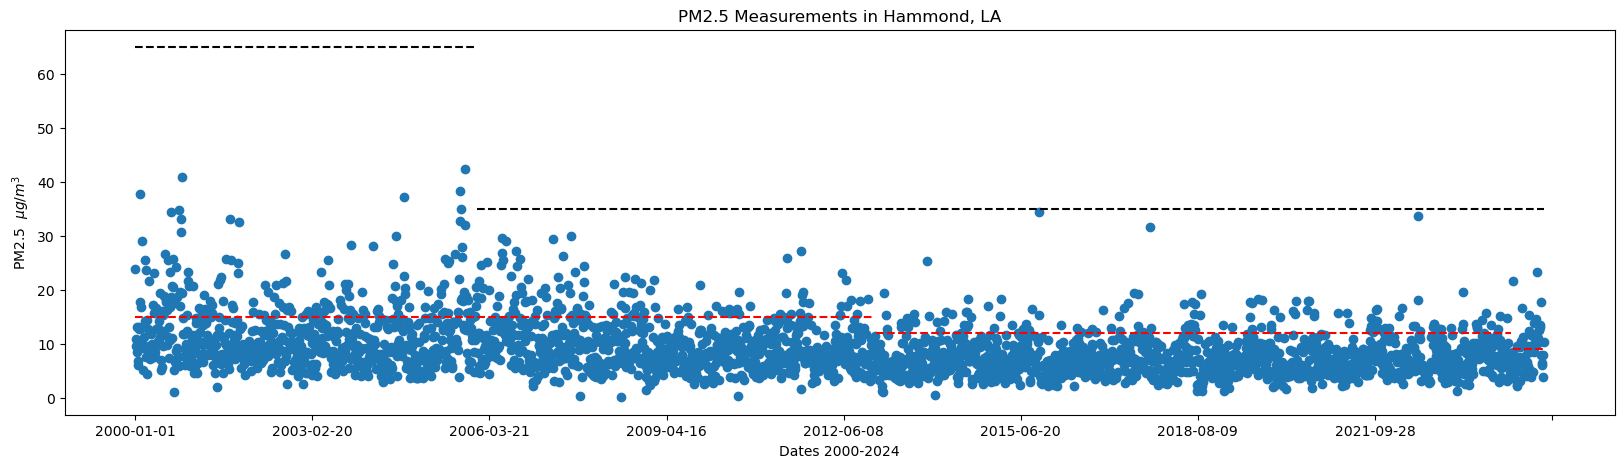

In [339]:
fig = plt.figure(figsize=(20, 5))
ax = plt.gca()

plt.scatter(dates,avg_pm_vals)

# Draw red lines to mark annual limits
plt.plot(['2024-01-01','2024-12-29'],[9,9], c='r', linestyle = 'dashed')
plt.plot(['2013-01-01','2023-12-29'],[12,12], c='r', linestyle = 'dashed')
plt.plot(['2000-01-01','2012-12-29'],[15,15], c='r', linestyle = 'dashed')

# Draw black lines to mark daily limits
plt.plot(['2006-01-02','2024-12-29'],[35,35], c='black', linestyle = 'dashed')
plt.plot(['2000-01-01','2005-12-30'],[65,65], c='black', linestyle = 'dashed')

plt.xlabel('Dates 2000-2024')
plt.ylabel('PM2.5  $\mu g/m^3$')

plt.title('PM2.5 Measurements in Hammond, LA')

# Make x-ticks nicer
ax.xaxis.set_major_locator(mdates.YearLocator(1,1,1))

plt.show()